In [260]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model 
from matplotlib import pyplot as plt
import time

# Load training times
train_epl00 = pd.read_csv('./data/EPL00_01.csv', encoding="ISO-8859-1")
train_epl01 = pd.read_csv('./data/EPL01_02.csv', encoding="ISO-8859-1")
train_epl02 = pd.read_csv('./data/EPL02_03.csv', encoding="ISO-8859-1")

# Load testing files
test_epl03 = pd.read_csv('./data/EPL03_04.csv', encoding="ISO-8859-1")
test_epl04 = pd.read_csv('./data/EPL04_05.csv', encoding="ISO-8859-1")

# Concat all training and test files into one structure
df_train = pd.concat((train_epl00, train_epl01, train_epl02), axis=0, ignore_index=True)
df_test = pd.concat((test_epl03, test_epl04), axis=0, ignore_index=True)

In [261]:
# Number of records in training set
num_train = df_train.shape[0]
print(str(num_train) + " records read from multiple training files")

# Number of records in test set
num_test = df_test.shape[0]
print(str(num_test) + " records read from multiple test files")

1140 records read from multiple training files
760 records read from multiple test files


In [270]:
# Calculate points from FTR (Full time Result)
def points(set_type):
    set_type['Result'] = np.NaN
    
    for index, item in set_type['FTR'].iteritems():
        if (item == 'H'):
            set_type.set_value(index, 'Result', 3.0)
        elif (item == 'A'):
            set_type.set_value(index, 'Result', 0.0)
        else:
            set_type.set_value(index, 'Result', 1.0)

# Calculate goal difference
def score_diff(set_type):
    set_type['Goal_diff'] = np.NaN # Set all values to zero
    home_g = set_type.FTHG # Placeholder values
    away_g = set_type.FTAG
    set_type['Goal_diff'] = home_g - away_g # Calculate the difference in fulltime scores
    

points(df_train)
score_diff(df_train)
    
# This is just to play around to see if it works
# This produces data where arsenal were the home team!
arsenal_str = 'Arsenal'      
arsenal = df_train.loc[(df_train['HomeTeam'] == arsenal_str) | (df_train['AwayTeam'] == arsenal_str)]

In [271]:
# These columns were dropped so that we could extract values!
ars_del = arsenal.drop(['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Result'], axis = 1)

In [273]:
# Normalize values 

# Transform to numpy array
ars_val = ars_del.values.astype(float)

# Activate sklearn - normalize object
min_max_scaler = preprocessing.MinMaxScaler()
ars_scaled = min_max_scaler.fit_transform(ars_val)

print('Number of samples:' , ars_scaled.shape[0])


# Turn it back into a dataframe
# df_ars_norm = pd.DataFrame(ars_scaled)
# print('Number of samples:' , df_ars_norm.shape[0]) # 57 samples
# print('Number of features:', df_ars_norm.shape[1]) # 14 features

Number of samples: 114


In [277]:
# Do linear regression testing on goal_diff (last feature)
ars_X  = ars_scaled[:, np.newaxis, -1]

target = np.array(arsenal['Result'])

# Split the data into training/testing sets
ars_X_train = ars_X[:-57]
ars_X_test = ars_X[-57:]

# One-Dim array of result values - targest
result = ars_scaled[:, np.newaxis, -2]
result = result.flatten()

# Split the targets into training/testing sets
ars_y_train = target[:-57]
ars_y_test = target[-57:]

Coefficients: 
 [ 4.68771727]
Residual sum of squares: 0.50
Variance score: 0.72


C:\Users\oakejp12\AppData\Local\Continuum\Miniconda3\envs\csc322\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


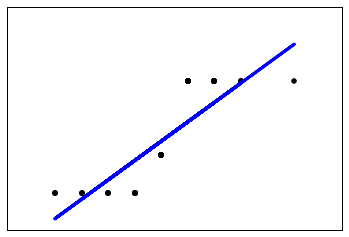

In [278]:
# Create a Linear Regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(ars_X_train, ars_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f" % np.mean((regr.predict(ars_X_test) - ars_y_test)** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(ars_X_test, ars_y_test))

# Plot outputs
plt.scatter(ars_X_test, ars_y_test, color='black')
plt.plot(ars_X_test, regr.predict(ars_X_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()